In [ ]:
import numpy as np
import xarray as xr

import rasterio.features
import stackstac
import pystac_client
import planetary_computer

import xrspatial.multispectral as ms

from skimage.feature import graycomatrix, graycoprops
from skimage import data
import pandas as pd
import geopandas as gpd
from datetime import datetime
from shapely.geometry import shape
import shapely
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



## Step 1

Extract SandSnap data to a pandas dataframe. Clean the dataframe, rename columns and drop unused columns

Clean the date format

In [2]:
sandsnap_df = pd.read_csv('../data/sandsnap-norcal.csv')
sandsnap_df['date'] =  pd.to_datetime(sandsnap_df['CreationDate'], format='%m/%d/%y',infer_datetime_format=True).dt.date
sandsnap_df

,objectid,GlobalID,City,Sample ID,Coin Reference,Location on Beach,Other,CreationDate,Creator,EditDate,...,blurry_metric,ab_value,pixel_count,reprocess_record,reprocess_all_records,Calculated Grain Size,Analysis Status,x,y,date
0,261,de1184c4-f446-4e58-9016-94cdbd0cfc15,Ocean Beach,Ocean Beach #6,nickel,the_swash,NaN,9/15/2021 3:16:29 PM,rose.dopsovic,2/28/2022 6:43:05 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.511641,37.757227,2021-09-15
1,161,a92dd1c3-8c2a-4743-b263-9264aa2e1817,Muir Beach,Muir #1,nickel,the_swash,the_swash,9/9/2021 5:36:45 PM,rose.dopsovic,8/22/2022 3:49:59 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.577900,37.859780,2021-09-09
2,407,659c1e24-ee14-40d8-ad2a-dd87c5f1b7f2,Morro Bay,Morro Bay #1,nickel,the_swash,NaN,11/23/2021 3:36:49 PM,rose.dopsovic,2/28/2022 6:43:05 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-120.875393,35.414916,2021-11-23
3,169,1cb14976-17e4-4d78-a852-0d87e146350e,Stinson Beach,Stinson #5,nickel,the_swash,the_swash,9/9/2021 5:36:48 PM,rose.dopsovic,8/22/2022 3:50:45 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.654300,37.902810,2021-09-09
4,470,82f720e1-44f0-47b4-a1f3-ce74d958244a,San Francisco,Ocean Beach #1,nickel,the_swash,NaN,3/9/2022 6:12:35 PM,rose.dopsovic,3/9/2022 6:27:49 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.513312,37.769927,2022-03-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,260,2de863d8-435b-438c-8800-1e9dfc574168,Ocean Beach,Ocean Beach #5,nickel,the_swash,NaN,9/15/2021 3:16:29 PM,rose.dopsovic,2/28/2022 6:43:05 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.511939,37.760022,2021-09-15
75,266,be1a1229-3d9b-49c4-ab5d-a81ccf1b3d6e,Marina,Marina S B #3,nickel,the_swash,NaN,9/15/2021 3:16:31 PM,rose.dopsovic,2/28/2022 6:43:05 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-121.810682,36.696127,2021-09-15
76,412,7a629c32-32f5-4b23-9ac3-548302cc881f,Morro Bay,Morro Bay #6,nickel,the_swash,NaN,11/23/2021 3:36:52 PM,rose.dopsovic,2/28/2022 6:43:05 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-120.872413,35.407279,2021-11-23
77,74,8182f028-cfea-4afb-80c2-063d9df26205,Bodega Bay,Bodega #6,nickel,the_berm,NaN,6/11/2021 5:28:53 PM,rose.dopsovic,2/28/2022 6:43:05 PM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-123.069125,38.333124,2021-06-11


### Summary stats for grain size params

In [3]:
sandsnap_df[['D10 mm','D50 mm','D90 mm','DMEAN mm']].describe()


,D10 mm,D50 mm,D90 mm,DMEAN mm
count,79.000000,79.000000,79.000000,79.000000
mean,0.466116,0.707845,1.151828,0.712933
std,0.100716,0.153931,0.251145,0.154833
min,0.271043,0.410349,0.666954,0.413539
25%,0.400098,0.606782,0.986798,0.611333
50%,0.447485,0.677474,1.101419,0.682741
75%,0.529818,0.803140,1.307744,0.808755
max,0.750660,1.136470,1.847144,1.145306


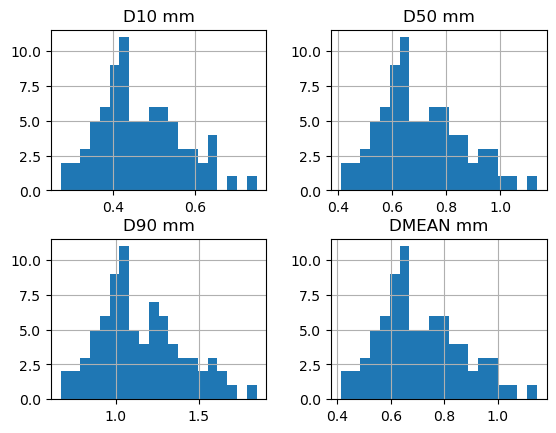

In [4]:
sandsnap_df[['D10 mm','D50 mm','D90 mm','DMEAN mm']].hist(bins=20)
plt.show()

In [5]:
sandsnap_df.dtypes

objectid                                                                                   int64
GlobalID                                                                                  object
City                                                                                      object
Sample ID                                                                                 object
Coin Reference                                                                            object
Location on Beach                                                                         object
Other                                                                                     object
CreationDate                                                                              object
Creator                                                                                   object
EditDate                                                                                  object
Editor                        

### Organize dataframe

In [45]:
world = sandsnap_df[['objectid','Location on Beach','D10 mm','D50 mm','D90 mm','DMEAN mm','Processing Status','date','x','y']]
world = world.rename(columns={'D90 mm':'D90','D50 mm':'D50','D10 mm':'D10','DMEAN mm':'DMEAN','x':'lon', 'y':'lat','Location on Beach':'beach_location'}) #Rename the field

world = world[world['Processing Status'] == 'ok'].drop('Processing Status',axis='columns')

keyword = "the_berm"
world = world[world['beach_location'].str.contains(keyword, na=False)].reset_index(drop=True)
world

,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat
0,75,the_berm,0.433855,0.661307,1.077571,0.665601,2021-06-11,-123.068107,38.339941
1,78,the_berm,0.577085,0.880677,1.435799,0.886127,2021-06-11,-123.068733,38.334629
2,796,the_berm,0.463797,0.702170,1.141261,0.707629,2022-09-24,-121.978298,36.956426
3,1151,the_berm,0.454081,0.687461,1.117354,0.692806,2023-02-14,-121.941207,36.618313
4,739,the_berm,0.529515,0.801665,1.302974,0.807897,2022-09-15,-122.980225,38.067190
5,70,"the_berm,the_swash",0.750660,1.136470,1.847144,1.145306,2021-06-11,-122.199978,37.012996
6,682,the_berm,0.517448,0.783396,1.273281,0.789486,2022-08-27,-123.064563,38.304393
7,737,the_berm,0.409044,0.619277,1.006533,0.624092,2022-09-15,-122.977104,38.074264
8,73,the_berm,0.495569,0.755629,1.231447,0.760470,2021-06-11,-123.067958,38.342355
9,740,the_berm,0.530120,0.802582,1.304464,0.808821,2022-09-15,-122.988206,38.049824


## Iterate over each entry and analyze

We will use a naive extraction method, which will be wasteful because these coordinates are likely to be covered by one or few NAIP tiles. But for the sake of simplicity, we will extract the NAIP tile that overlaps with each coordinate, and construct the texture features


In [46]:
side_len_deg = 0.0001 #~11.1m

In [47]:
def bbox(lon, lat, side_len_deg = 0.0001):
    point_geom  = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))
    point_shape = shapely.geometry.shape(point_geom)
    #Create a square out of it with side_length = buffer*2
    mask_shape  = point_shape.buffer(side_len_deg/2.).envelope
    aoi   = shapely.geometry.mapping(mask_shape)
    return aoi
    # return rasterio.features.bounds(aoi)

Using pystac_client we can search the Planetary Computer's STAC endpoint for items matching our query parameters.

## Functions to extract NAIP tiles for each entry

In [48]:
collection = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [49]:
#returns the closest date 
def nearest_date(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

To select the nearest time to a desired time value, we set it to use a nearest neighbour method, 'nearest'. We have to specify the time using a datetime object. [ref](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Frequently_used_code/Working_with_time.html)

TODO:
1. Select closest date
2. Check for rainfall near that date - some temporal buffer


In [50]:
import operator

def cropCenter(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [51]:
BANDS = ["B04","B03","B02", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]

In [52]:
import pyproj

GSD = 10.0 #m/px

def area_of_overlap(item, aoi):
    area_shape = shape(aoi)
    aoi_area = area_shape.area
    
    
    aoi_area = shape(aoi).area
    
    overlap_area = shape(item.geometry).intersection(shape(aoi)).area
    # print(aoi_area, overlap_area)
    return overlap_area / aoi_area


def S2_data(date, lon, lat, bands = BANDS,\
            limit_months=5, window_size_px=10, add_to_map=None):
    """
    parameters:
    date: datetime object of the time of observation capture
    lon, lat : coordinates of observation
    bands : list of Sentinel 2 band names
    limit_months : maximum duration before and after date to search for
    buffer : area to crop around (lon,lat) in meters, i.e. a square with side buffer
    
    return type:
    window_size_px : if > 1, will return a numpy array DN values at all pixels within window
            if 1, will return a list of DN values per band at that pixel
    """
    
    #Create a window of limit_months around the acquisition date to search for NAIP data
    start_date, end_date = date - relativedelta(months=int(limit_months/2)), \
                            date + relativedelta(months=int(limit_months/2))


    date_range = start_date.strftime('%Y-%m-%d') + "/" + end_date.strftime('%Y-%m-%d')
    
    aoi = bbox(lon, lat)

    search = collection.search(
        # bbox=aoi, 
        intersects=aoi,
        datetime=date_range,
        collections=["sentinel-2-l2a"],
        query={"eo:cloud_cover": {"lt": 10}},
        limit=20,
    )
    
    items = search.item_collection()
    
    if len(items) == 0:
        print ("No tiles found in ", date_range)
        return None
    
    if len(items) > 0:
        tile = items[0]
    else:
        tile = items
    
        
    delta_days = abs((tile.datetime.date() - date).days)
    
    if len(items) > 0:
        delta_min = 1e9
        
        #Choose the item that's closest in time to the sandsnap item's
        for i, item in enumerate(items):
            delta_days = abs((item.datetime.date() - date).days)
            # print(delta_days)
            if delta_days < delta_min:
                delta_min = delta_days
                tile = item
                
    #Make sure area of overlap is 100%
    if area_of_overlap(tile,aoi) != 1:
        return None
    
    # print("{:} overlapping tile(s) for: {:} | Delta:{:} days"\
    #   .format(len(items),date_range,delta_days))
    
    chosen = stackstac.stack(
        tile,
        assets=bands, 
        # epsg = crs,
        # epsg=3857,
        # chunksize=4096,
        # resolution=100,
    ).where(lambda x: x > 0, other=np.nan).assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names \  # sentinel-2 uses 0 as nodata
    tile = chosen[0] #still has time dimension - removing with this step

    #This is done because the different S2 tiles can have different UTM zones and CRS's
    #that trips up Stackstac -> so choose the epsg as one of them and force them all to be the same
    #OR bypass this process all together and use simple logic to choose the closest date
#     crs = items[0].properties['proj:epsg']
    
#     #convert to xarray with stacstac
#     all_bands = stackstac.stack(
#         items,
#         assets=bands, 
#         epsg = crs,
#         # epsg=3857,
#         # chunksize=4096,
#         # resolution=100,
#     ).where(lambda x: x > 0, other=np.nan).assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names \  # sentinel-2 uses 0 as nodata
    
#     # display(all_bands)
    
#     #Find the one with the closest to date of observation
#     #Doesnt work
#     # return data.sel(time=target_time, method='nearest')
    
#     if all_bands.sizes['time'] > 1: #when the collection (i.e. time dimension) has more than one entry
#         tile = all_bands.sortby(all_bands['eo:cloud_cover'])[0]
#     else:
#         tile = all_bands
    
    # return data
    #Now crop out the AOI:
    x_utm, y_utm = pyproj.Proj(tile.crs)(lon, lat)
    
    #define buffer size in meter to be about 20% larger than required window size
    buffer_m = 100
    window_size_m = window_size_px*GSD
    
    #Make sure buffer isnt too small to correct for skewing of crop box
    buffer_m = window_size_m if window_size_m > buffer_m else buffer_m
    
    aoi = tile.loc[..., y_utm+(buffer_m/2.):y_utm-(buffer_m/2.), x_utm-(buffer_m/2.):x_utm+(buffer_m/2.)]
    # rgb = aoi.sel(band=["red", "green", "blue"])
    aoi = aoi.compute()
    
    # display(aoi)
    aoi_np = aoi.to_numpy()
    
    #Now crop to window size:
    img_patch = cropCenter(aoi_np, (aoi_np.shape[0],window_size_px,window_size_px)) #4 for 4 channels
    
    if add_to_map:
        
        stackstac.add_to_map(aoi[0:3], add_to_map, "", range=[0, 3000])
        marker = ipyleaflet.Marker(location=(lat,lon), draggable=False)
        add_to_map.add_layer(marker);
    
    if img_patch.shape[1] == 1 and img_patch.shape[2] == 1: #i.e. the number of pixels is one
        return img_patch.reshape(len(img_patch)).tolist()
    return img_patch
    

## Update DF with band values

In [53]:
#drop the first entry, aka outlier with D50 = 3.5mm
# world = world.drop(world.index[0]).reset_index(drop=True)

for band in BANDS:
    world[band] = np.NaN

world['span'] = (world['D90'] - world['D10'])/world['D50']
    
world

,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,span
0,75,the_berm,0.433855,0.661307,1.077571,0.665601,2021-06-11,-123.068107,38.339941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.973399
1,78,the_berm,0.577085,0.880677,1.435799,0.886127,2021-06-11,-123.068733,38.334629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.975061
2,796,the_berm,0.463797,0.702170,1.141261,0.707629,2022-09-24,-121.978298,36.956426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964816
3,1151,the_berm,0.454081,0.687461,1.117354,0.692806,2023-02-14,-121.941207,36.618313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964816
4,739,the_berm,0.529515,0.801665,1.302974,0.807897,2022-09-15,-122.980225,38.067190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964816
5,70,"the_berm,the_swash",0.750660,1.136470,1.847144,1.145306,2021-06-11,-122.199978,37.012996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964816
6,682,the_berm,0.517448,0.783396,1.273281,0.789486,2022-08-27,-123.064563,38.304393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964816
7,737,the_berm,0.409044,0.619277,1.006533,0.624092,2022-09-15,-122.977104,38.074264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964816
8,73,the_berm,0.495569,0.755629,1.231447,0.760470,2021-06-11,-123.067958,38.342355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.973861
9,740,the_berm,0.530120,0.802582,1.304464,0.808821,2022-09-15,-122.988206,38.049824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964816


In [42]:
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
import time
from IPython.display import clear_output

def get_values(df, m):
    """
    """
    
    keep = False
    for index, sample in tqdm(df.iterrows(), total=df.shape[0]): #shape is required to tell tqdm the total elements
        m.center = sample['lat'],sample['lon']
        DNs_point = S2_data(sample['date'], sample['lon'], sample['lat'], window_size_px=200, add_to_map=m)
        # time.sleep(10)
        if DNs_point is None:
            print("No tiles for ", sample['objectid'])
            continue
        
        display(sample)
        inp = input("[{:} {:} {:}] Enter y to keep / anything else to discard: ".format(sample['objectid'],  sample['lat'], sample['lon']))
        keep = inp == 'y'  
        # time.sleep(5)
        clear_output()
        
        
        if (keep):
            DNs_point = S2_data(sample['date'], sample['lon'], sample['lat'], window_size_px=1)
            print("Kept Observation")
            for b, band in enumerate(BANDS):
                # print(b, band)
                df[band].iloc[index] = DNs_point[b]

        

In [16]:
from dask_gateway import GatewayCluster
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=8, maximum=24)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.af76d269b9204b248f9195f9b090f35b/status


In [20]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.af76d269b9204b248f9195f9b090f35b/status,


In [34]:
import ipyleaflet
m = ipyleaflet.Map()
m.center = center = world['lat'][0],world['lon'][0]
m.zoom = 16
m.layout.height = "700px"
#stackstac.add_to_map(tile1[4:7], m, "s2", range=[0, 3000])
display(m)

Map(center=[37.757226916, -122.511641009], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…

In [54]:
test = world[0:3]
# %%time
client.wait_for_workers(2, timeout=10)
get_values(world, m)
world


Kept Observation


,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,span
0,75,the_berm,0.433855,0.661307,1.077571,0.665601,2021-06-11,-123.068107,38.339941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.973399
1,78,the_berm,0.577085,0.880677,1.435799,0.886127,2021-06-11,-123.068733,38.334629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.975061
2,796,the_berm,0.463797,0.702170,1.141261,0.707629,2022-09-24,-121.978298,36.956426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964816


In [55]:
world

,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,span
0,75,the_berm,0.433855,0.661307,1.077571,0.665601,2021-06-11,-123.068107,38.339941,1344.0,1254.0,1046.0,1382.0,1379.0,1403.0,1384.0,1391.0,2001.0,1917.0,0.973399
1,78,the_berm,0.577085,0.880677,1.435799,0.886127,2021-06-11,-123.068733,38.334629,1480.0,1352.0,1158.0,1486.0,1446.0,1468.0,1518.0,1412.0,2030.0,1964.0,0.975061
2,796,the_berm,0.463797,0.702170,1.141261,0.707629,2022-09-24,-121.978298,36.956426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964816
3,1151,the_berm,0.454081,0.687461,1.117354,0.692806,2023-02-14,-121.941207,36.618313,4356.0,4152.0,3718.0,4914.0,5208.0,5322.0,5424.0,5440.0,5332.0,5035.0,0.964816
4,739,the_berm,0.529515,0.801665,1.302974,0.807897,2022-09-15,-122.980225,38.067190,2800.0,2624.0,2344.0,2773.0,2796.0,2772.0,2928.0,2768.0,3184.0,3078.0,0.964816
5,70,"the_berm,the_swash",0.750660,1.136470,1.847144,1.145306,2021-06-11,-122.199978,37.012996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964816
6,682,the_berm,0.517448,0.783396,1.273281,0.789486,2022-08-27,-123.064563,38.304393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964816
7,737,the_berm,0.409044,0.619277,1.006533,0.624092,2022-09-15,-122.977104,38.074264,2752.0,2586.0,2264.0,2847.0,2748.0,2814.0,2832.0,2732.0,3420.0,3440.0,0.964816
8,73,the_berm,0.495569,0.755629,1.231447,0.760470,2021-06-11,-123.067958,38.342355,1656.0,1534.0,1266.0,1727.0,1770.0,1865.0,1894.0,1808.0,2566.0,2401.0,0.973861
9,740,the_berm,0.530120,0.802582,1.304464,0.808821,2022-09-15,-122.988206,38.049824,2540.0,2410.0,2130.0,2638.0,2542.0,2573.0,2606.0,2564.0,3044.0,3051.0,0.964816


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm

def get_point_values(df):
    """
    """
    for index, sample in tqdm(df.iterrows(), total=df.shape[0]): #shape is required to tell tqdm the total elements
     
        DNs_point = S2_data(sample['date'], sample['lon'], sample['lat'], window_size_px=1000)
        
        if DNs_point is None:
            print("No tiles for ", sample['objectid'])
            continue
        # print(DNs_point)
        #write to df
        for b, band in enumerate(BANDS):
            # print(b, band)
            df[band].iloc[index] = DNs_point[b]

Wait for 4 workers for upto 10 seconds

In [15]:
keep = False
for i in range(3):
    inp = input("Enter y to keep/ anything else to discard: ")
    
    keep = inp == 'y'
    print(keep)
    
    

Enter y to keep/ anything else to discard:  n


False


Enter y to keep/ anything else to discard:  y


True


Enter y to keep/ anything else to discard:  kkk


False


In [25]:
%%time
client.wait_for_workers(4, timeout=10)
get_point_values(world)
world



  0%|          | 0/701 [00:00<?, ?it/s]

No tiles found in  2022-06-05/2022-10-05
No tiles for  660
No tiles for  1056


IndexError: iloc cannot enlarge its target object

In [56]:
world

,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,span
0,75,the_berm,0.433855,0.661307,1.077571,0.665601,2021-06-11,-123.068107,38.339941,1344.0,1254.0,1046.0,1382.0,1379.0,1403.0,1384.0,1391.0,2001.0,1917.0,0.973399
1,78,the_berm,0.577085,0.880677,1.435799,0.886127,2021-06-11,-123.068733,38.334629,1480.0,1352.0,1158.0,1486.0,1446.0,1468.0,1518.0,1412.0,2030.0,1964.0,0.975061
2,796,the_berm,0.463797,0.702170,1.141261,0.707629,2022-09-24,-121.978298,36.956426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964816
3,1151,the_berm,0.454081,0.687461,1.117354,0.692806,2023-02-14,-121.941207,36.618313,4356.0,4152.0,3718.0,4914.0,5208.0,5322.0,5424.0,5440.0,5332.0,5035.0,0.964816
4,739,the_berm,0.529515,0.801665,1.302974,0.807897,2022-09-15,-122.980225,38.067190,2800.0,2624.0,2344.0,2773.0,2796.0,2772.0,2928.0,2768.0,3184.0,3078.0,0.964816
5,70,"the_berm,the_swash",0.750660,1.136470,1.847144,1.145306,2021-06-11,-122.199978,37.012996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964816
6,682,the_berm,0.517448,0.783396,1.273281,0.789486,2022-08-27,-123.064563,38.304393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964816
7,737,the_berm,0.409044,0.619277,1.006533,0.624092,2022-09-15,-122.977104,38.074264,2752.0,2586.0,2264.0,2847.0,2748.0,2814.0,2832.0,2732.0,3420.0,3440.0,0.964816
8,73,the_berm,0.495569,0.755629,1.231447,0.760470,2021-06-11,-123.067958,38.342355,1656.0,1534.0,1266.0,1727.0,1770.0,1865.0,1894.0,1808.0,2566.0,2401.0,0.973861
9,740,the_berm,0.530120,0.802582,1.304464,0.808821,2022-09-15,-122.988206,38.049824,2540.0,2410.0,2130.0,2638.0,2542.0,2573.0,2606.0,2564.0,3044.0,3051.0,0.964816


In [58]:
world[['D10','D50','D90','DMEAN']].describe()

,D10,D50,D90,DMEAN
count,22.000000,22.000000,22.000000,22.000000
mean,0.476605,0.723367,1.176835,0.728640
std,0.115638,0.175729,0.286046,0.176963
min,0.271043,0.410349,0.666954,0.413539
25%,0.410464,0.621426,1.010026,0.626258
50%,0.479683,0.728900,1.186354,0.734049
75%,0.529969,0.802352,1.304092,0.808590
max,0.750660,1.136470,1.847144,1.145306


array([[<AxesSubplot:title={'center':'D10'}>,
        <AxesSubplot:title={'center':'D50'}>],
       [<AxesSubplot:title={'center':'D90'}>,
        <AxesSubplot:title={'center':'DMEAN'}>]], dtype=object)

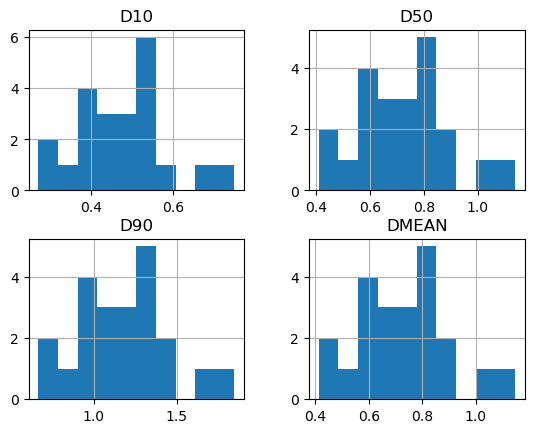

In [59]:
world[['D10','D50','D90','DMEAN']].hist()

## Multiple regression

### Remove all NaNs

In [60]:
df = world[world['B02'].notna()].reset_index(drop=True).copy()
df

,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,span
0,75,the_berm,0.433855,0.661307,1.077571,0.665601,2021-06-11,-123.068107,38.339941,1344.0,1254.0,1046.0,1382.0,1379.0,1403.0,1384.0,1391.0,2001.0,1917.0,0.973399
1,78,the_berm,0.577085,0.880677,1.435799,0.886127,2021-06-11,-123.068733,38.334629,1480.0,1352.0,1158.0,1486.0,1446.0,1468.0,1518.0,1412.0,2030.0,1964.0,0.975061
2,1151,the_berm,0.454081,0.687461,1.117354,0.692806,2023-02-14,-121.941207,36.618313,4356.0,4152.0,3718.0,4914.0,5208.0,5322.0,5424.0,5440.0,5332.0,5035.0,0.964816
3,739,the_berm,0.529515,0.801665,1.302974,0.807897,2022-09-15,-122.980225,38.067190,2800.0,2624.0,2344.0,2773.0,2796.0,2772.0,2928.0,2768.0,3184.0,3078.0,0.964816
4,737,the_berm,0.409044,0.619277,1.006533,0.624092,2022-09-15,-122.977104,38.074264,2752.0,2586.0,2264.0,2847.0,2748.0,2814.0,2832.0,2732.0,3420.0,3440.0,0.964816
5,73,the_berm,0.495569,0.755629,1.231447,0.760470,2021-06-11,-123.067958,38.342355,1656.0,1534.0,1266.0,1727.0,1770.0,1865.0,1894.0,1808.0,2566.0,2401.0,0.973861
6,740,the_berm,0.530120,0.802582,1.304464,0.808821,2022-09-15,-122.988206,38.049824,2540.0,2410.0,2130.0,2638.0,2542.0,2573.0,2606.0,2564.0,3044.0,3051.0,0.964816
7,377,the_berm,0.499791,0.762303,1.242500,0.767128,2021-10-16,-122.490094,37.826921,698.0,513.0,395.0,928.0,969.0,1006.0,833.0,1092.0,1521.0,1306.0,0.974296
8,76,the_berm,0.453808,0.692437,1.128823,0.696748,2021-06-11,-123.068371,38.338042,1530.0,1424.0,1146.0,1412.0,1488.0,1532.0,1858.0,1520.0,1902.0,1782.0,0.974840
9,915,the_berm,0.374936,0.567639,0.922603,0.572052,2022-11-11,-121.964696,36.587474,3754.0,3596.0,3280.0,4751.0,4743.0,4750.0,4468.0,4972.0,4116.0,3747.0,0.964816


In [61]:
df.isna().sum()

objectid          0
beach_location    0
D10               0
D50               0
D90               0
DMEAN             0
date              0
lon               0
lat               0
B04               0
B03               0
B02               0
B05               0
B06               0
B07               0
B08               0
B8A               0
B11               0
B12               0
span              0
dtype: int64

## Convert Band values to absolute reflectance

For Sentinel-2 optical data (L2A), the relation between DN and REFLECTANCE (default unit) is: DN = 10000 * REFLECTANCE [Source](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/)

Therefore divide by 10000. to get the reflectance value

In [62]:
df[BANDS] = df[BANDS]/(10000.)
df

,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,span
0,75,the_berm,0.433855,0.661307,1.077571,0.665601,2021-06-11,-123.068107,38.339941,0.1344,0.1254,0.1046,0.1382,0.1379,0.1403,0.1384,0.1391,0.2001,0.1917,0.973399
1,78,the_berm,0.577085,0.880677,1.435799,0.886127,2021-06-11,-123.068733,38.334629,0.1480,0.1352,0.1158,0.1486,0.1446,0.1468,0.1518,0.1412,0.2030,0.1964,0.975061
2,1151,the_berm,0.454081,0.687461,1.117354,0.692806,2023-02-14,-121.941207,36.618313,0.4356,0.4152,0.3718,0.4914,0.5208,0.5322,0.5424,0.5440,0.5332,0.5035,0.964816
3,739,the_berm,0.529515,0.801665,1.302974,0.807897,2022-09-15,-122.980225,38.067190,0.2800,0.2624,0.2344,0.2773,0.2796,0.2772,0.2928,0.2768,0.3184,0.3078,0.964816
4,737,the_berm,0.409044,0.619277,1.006533,0.624092,2022-09-15,-122.977104,38.074264,0.2752,0.2586,0.2264,0.2847,0.2748,0.2814,0.2832,0.2732,0.3420,0.3440,0.964816
5,73,the_berm,0.495569,0.755629,1.231447,0.760470,2021-06-11,-123.067958,38.342355,0.1656,0.1534,0.1266,0.1727,0.1770,0.1865,0.1894,0.1808,0.2566,0.2401,0.973861
6,740,the_berm,0.530120,0.802582,1.304464,0.808821,2022-09-15,-122.988206,38.049824,0.2540,0.2410,0.2130,0.2638,0.2542,0.2573,0.2606,0.2564,0.3044,0.3051,0.964816
7,377,the_berm,0.499791,0.762303,1.242500,0.767128,2021-10-16,-122.490094,37.826921,0.0698,0.0513,0.0395,0.0928,0.0969,0.1006,0.0833,0.1092,0.1521,0.1306,0.974296
8,76,the_berm,0.453808,0.692437,1.128823,0.696748,2021-06-11,-123.068371,38.338042,0.1530,0.1424,0.1146,0.1412,0.1488,0.1532,0.1858,0.1520,0.1902,0.1782,0.974840
9,915,the_berm,0.374936,0.567639,0.922603,0.572052,2022-11-11,-121.964696,36.587474,0.3754,0.3596,0.3280,0.4751,0.4743,0.4750,0.4468,0.4972,0.4116,0.3747,0.964816


## Find outliers


<AxesSubplot:xlabel='objectid', ylabel='D50'>

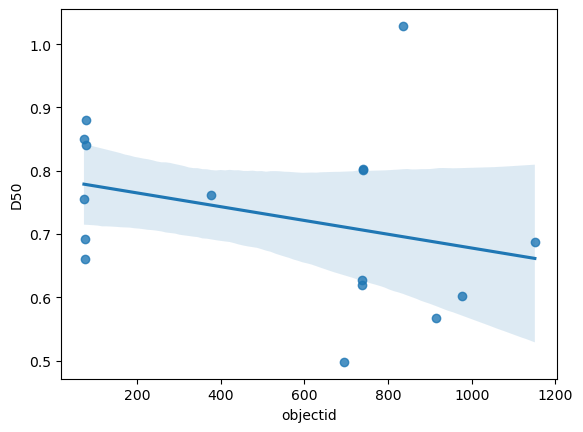

In [63]:
sns.regplot(x='objectid', y='D50', data=df)




In [31]:
df[df.D50 > 2.5]

,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,span
70,92,the_dune,2.368181,3.595201,5.848548,3.621643,2021-06-11,-73.556896,40.580327,0.0853,0.1013,0.0788,0.0789,0.0267,0.0359,0.0404,0.0356,0.0359,0.0324,0.968059


We know from a qualitative inspection of this observation that it had a bunch of shells in it, in an otherwise relatively homogenous grain distribution. 
Also there were many data points nearby which all had much lower D50. Hence, remove

In [32]:
df = df[df.D50 < 2.5].reset_index(drop=True)
df

,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,span
0,1,the_swash,0.325274,0.492118,0.799712,0.496004,2021-06-11,-65.988747,17.973859,0.0940,0.1282,0.1312,0.1868,0.2137,0.2341,0.2876,0.2379,0.2201,0.1634,0.964073
1,2,the_berm,0.351877,0.533849,0.868260,0.537834,2021-06-11,-65.986842,18.458983,0.1628,0.2064,0.2404,0.2780,0.3134,0.3283,0.3098,0.3263,0.3248,0.2439,0.967283
2,4,the_dune,0.189226,0.286746,0.466192,0.288933,2021-06-11,-75.067763,38.665109,0.2752,0.3332,0.3770,0.4232,0.4321,0.4636,0.4676,0.4831,0.5931,0.5866,0.965894
3,5,"the_berm,other",0.293832,0.445790,0.725049,0.449119,2021-06-11,-75.067055,38.665189,0.2352,0.3138,0.3576,0.4026,0.4051,0.4199,0.4168,0.4329,0.5300,0.5340,0.967312
4,6,the_swash,0.302490,0.460296,0.749476,0.463461,2021-06-11,-75.066829,38.665184,0.1530,0.1860,0.2206,0.3070,0.3020,0.3068,0.2540,0.3383,0.3219,0.3045,0.971084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,1213,the_swash,0.616246,0.932972,1.516392,0.940226,2023-03-03,12.234767,55.537246,0.1516,0.1794,0.1772,0.2405,0.3223,0.3585,0.3380,0.3943,0.3187,0.2740,0.964816
640,1214,the_swash,0.541715,0.820135,1.332994,0.826511,2023-03-04,12.157179,55.212933,0.4728,0.5396,0.5684,0.6632,0.6258,0.6422,0.7220,0.6560,0.4403,0.3095,0.964816
641,1226,the_dune,0.335783,0.508362,0.826259,0.512315,2023-03-13,-80.285356,27.451504,0.6268,0.6596,0.7144,0.7716,0.7668,0.7823,0.7688,0.7907,0.8571,0.8814,0.964816
642,1227,the_berm,0.335866,0.508487,0.826462,0.512441,2023-03-13,-80.284365,27.452367,0.2770,0.2996,0.3144,0.3502,0.3411,0.3445,0.3338,0.3500,0.4528,0.4342,0.964816


## Save file to disk

In [64]:
df.to_csv('../data/norcal-berm-reflectance.csv')



## Regress D50/D90/D10

In [65]:
import statsmodels.formula.api as smf 
#["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
# formula: response ~ predictor + predictor 
model = smf.ols(formula='D50 ~ B02 + B03 + B04 + B05 + B06 + B07 + B08 + B8A + B11 + B12', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     1.734
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.283
Time:                        22:05:30   Log-Likelihood:                 21.686
No. Observations:                  16   AIC:                            -21.37
Df Residuals:                       5   BIC:                            -12.87
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5157      0.276      1.870      0.120      -0.193       1.225
B02          -10.2947      8.618     -1.194      0.286     -32.449      11.860
B03           -1.7839     18.010     -0.099      0.925     -48.080      44.512
B04           10.3695     12.407      0.836      0.441     -21.523      42.262
B05           -2.4158      5.142     -0.470      0.658     -15.633      10.802
B06           17.5117     10.791      1.623      0.166     -10.227      45.250
B07           -6.9782     18.152     -0.384      0.716     -53.640      39.683
B08           -1.2464      4.902     -0.254      0.809     -13.848      11.355
B8A           -6.8557     17.472     -0.392      0.711     -51.769      38.057
B11            0.8902     10.192      0.087      0.934     -25.309      27.089
B12           -0.1501      7.991     -0.019      0.986     -20.690      20.390
==============================================================================
Omnibus:                        1.650   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.438   Jarque-Bera (JB):                0.267
Skew:                          -0.062   Prob(JB):                        0.875
Kurtosis:                       3.620   Cond. No.                     1.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [85]:
import statsmodels.formula.api as smf 
#["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
# formula: response ~ predictor + predictor 
model = smf.ols(formula='D50 ~ B04 + B07 + B11 + B12', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     1.654
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.230
Time:                        22:09:43   Log-Likelihood:                 13.479
No. Observations:                  16   AIC:                            -16.96
Df Residuals:                      11   BIC:                            -13.09
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6773      0.162      4.186      0.002       0.321       1.033
B04           -2.8174      2.538     -1.110      0.291      -8.404       2.769
B07            0.5142      2.280      0.225      0.826      -4.505       5.533
B11           -3.7911      5.979     -0.634      0.539     -16.950       9.368
B12            5.9388      5.086      1.168      0.268      -5.256      17.133
==============================================================================
Omnibus:                        1.223   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.543   Jarque-Bera (JB):                1.001
Skew:                          -0.542   Prob(JB):                        0.606
Kurtosis:                       2.430   Cond. No.                         294.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
import statsmodels.formula.api as smf 
#["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
# formula: response ~ predictor + predictor 
model = smf.ols(formula='D90 ~ B02 + B03 + B04 + B05 + B06 + B07 + B08 + B8A + B11 + B12', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D90   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     1.735
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.282
Time:                        22:05:58   Log-Likelihood:                 13.870
No. Observations:                  16   AIC:                            -5.740
Df Residuals:                       5   BIC:                             2.759
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8439      0.449      1.878      0.119      -0.311       1.999
B02          -16.7717     14.047     -1.194      0.286     -52.880      19.336
B03           -2.9698     29.353     -0.101      0.923     -78.425      72.486
B04           16.8124     20.221      0.831      0.444     -35.167      68.792
B05           -3.8900      8.380     -0.464      0.662     -25.432      17.652
B06           28.6410     17.587      1.629      0.164     -16.568      73.850
B07          -11.2733     29.585     -0.381      0.719     -87.324      64.777
B08           -1.9523      7.990     -0.244      0.817     -22.491      18.587
B8A          -11.3736     28.476     -0.399      0.706     -84.575      61.827
B11            1.3990     16.611      0.084      0.936     -41.301      44.099
B12           -0.2036     13.023     -0.016      0.988     -33.681      33.274
==============================================================================
Omnibus:                        1.671   Durbin-Watson:                   2.134
Prob(Omnibus):                  0.434   Jarque-Bera (JB):                0.276
Skew:                          -0.066   Prob(JB):                        0.871
Kurtosis:                       3.629   Cond. No.                     1.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
import statsmodels.formula.api as smf 
#["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
# formula: response ~ predictor + predictor 
model = smf.ols(formula='D10 ~ B02 + B03 + B04 + B05 + B06 + B07 + B08 + B8A + B11 + B12', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D10   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     1.730
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.283
Time:                        22:06:01   Log-Likelihood:                 28.434
No. Observations:                  16   AIC:                            -34.87
Df Residuals:                       5   BIC:                            -26.37
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3348      0.181      1.851      0.123      -0.130       0.800
B02           -6.7558      5.653     -1.195      0.286     -21.287       7.775
B03           -1.1145     11.813     -0.094      0.928     -31.480      29.251
B04            6.9000      8.138      0.848      0.435     -14.018      27.818
B05           -1.6351      3.373     -0.485      0.648     -10.304       7.034
B06           11.3798      7.078      1.608      0.169      -6.814      29.573
B07           -4.6727     11.906     -0.392      0.711     -35.278      25.933
B08           -0.8998      3.215     -0.280      0.791      -9.165       7.366
B8A           -4.2917     11.460     -0.375      0.723     -33.750      25.167
B11            0.6328      6.685      0.095      0.928     -16.551      17.817
B12           -0.1384      5.241     -0.026      0.980     -13.611      13.334
==============================================================================
Omnibus:                        1.596   Durbin-Watson:                   2.131
Prob(Omnibus):                  0.450   Jarque-Bera (JB):                0.245
Skew:                          -0.051   Prob(JB):                        0.885
Kurtosis:                       3.598   Cond. No.                     1.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.071
Method:                 Least Squares   F-statistic:                  0.003336
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.955
Time:                        22:06:05   Log-Likelihood:                 9.7135
No. Observations:                  16   AIC:                            -15.43
Df Residuals:                      14   BIC:                            -13.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7244      0.102      7.091      0.000       0.505       0.944
B11            0.0188      0.325      0.058      0.955      -0.678       0.716
==============================================================================
Omnibus:                        0.456   Durbin-Watson:                   2.237
Prob(Omnibus):                  0.796   Jarque-Bera (JB):                0.355
Skew:                           0.313   Prob(JB):                        0.837
Kurtosis:                       2.626   Cond. No.                         10.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D90   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.071
Method:                 Least Squares   F-statistic:                  0.001185
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.973
Time:                        22:06:05   Log-Likelihood:                 1.8910
No. Observations:                  16   AIC:                            0.2181
Df Residuals:                      14   BIC:                             1.763
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1825      0.167      7.099      0.000       0.825       1.540
B11            0.0182      0.530      0.034      0.973      -1.119       1.155
==============================================================================
Omnibus:                        0.445   Durbin-Watson:                   2.234
Prob(Omnibus):                  0.801   Jarque-Bera (JB):                0.348
Skew:                           0.309   Prob(JB):                        0.840
Kurtosis:                       2.626   Cond. No.                         10.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D10   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.070
Method:                 Least Squares   F-statistic:                   0.01429
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.907
Time:                        22:06:05   Log-Likelihood:                 16.482
No. Observations:                  16   AIC:                            -28.96
Df Residuals:                      14   BIC:                            -27.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4730      0.067      7.068      0.000       0.329       0.617
B11            0.0255      0.213      0.120      0.907      -0.431       0.482
==============================================================================
Omnibus:                        0.485   Durbin-Watson:                   2.246
Prob(Omnibus):                  0.785   Jarque-Bera (JB):                0.373
Skew:                           0.324   Prob(JB):                        0.830
Kurtosis:                       2.625   Cond. No.                         10.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

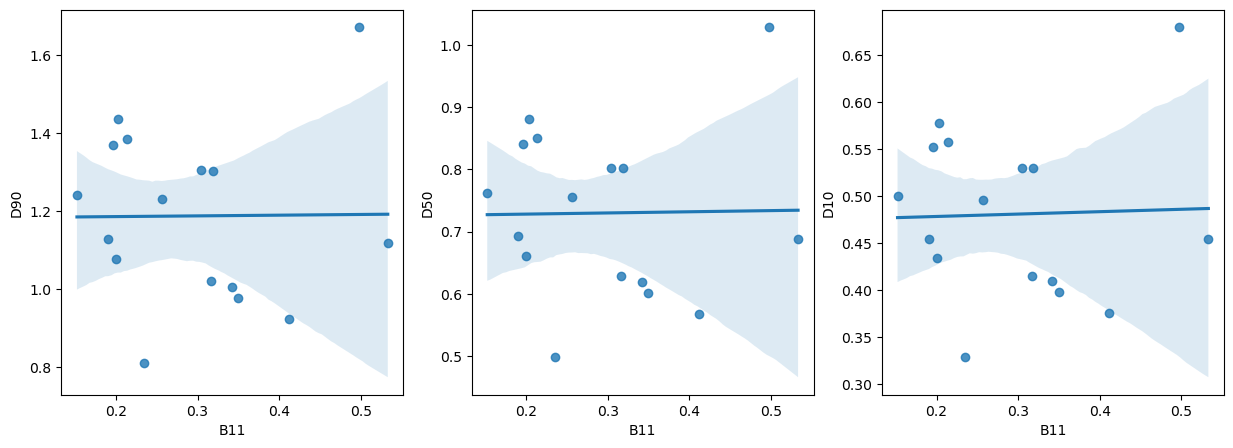

In [68]:
model2 = smf.ols(formula='D50 ~ B11', data=df).fit()
model1 = smf.ols(formula='D90 ~ B11', data=df).fit()
model3 = smf.ols(formula='D10 ~ B11', data=df).fit()
display(model2.summary())
display(model1.summary())
display(model3.summary())

fig, axs = plt.subplots(1, 3, sharex=True, figsize=(15,5))

sns.regplot(x='B11', y='D50', data=df, ax=axs[1])
sns.regplot(x='B11', y='D90', data=df, ax=axs[0])
sns.regplot(x='B11', y='D10', data=df, ax=axs[2])
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                    0.2708
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.611
Time:                        22:06:16   Log-Likelihood:                 9.8648
No. Observations:                  16   AIC:                            -15.73
Df Residuals:                      14   BIC:                            -14.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7659      0.078      9.880      0.000       0.600       0.932
B8A           -0.1428      0.274     -0.520      0.611      -0.731       0.446
==============================================================================
Omnibus:                        1.976   Durbin-Watson:                   2.115
Prob(Omnibus):                  0.372   Jarque-Bera (JB):                0.715
Skew:                           0.498   Prob(JB):                        0.699
Kurtosis:                       3.285   Cond. No.                         8.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='B8A', ylabel='D50'>

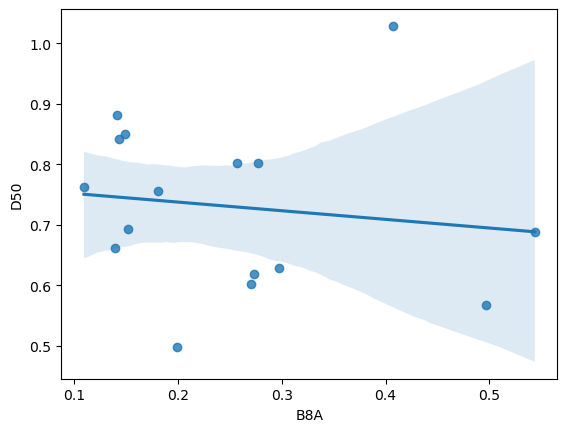

In [69]:
model_hom = smf.ols(formula='D50 ~ B8A', data=df).fit()
display(model_hom.summary())
sns.regplot(x='B8A', y='D50', data=df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.054
Method:                 Least Squares   F-statistic:                    0.2280
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.640
Time:                        22:06:16   Log-Likelihood:                 9.8408
No. Observations:                  16   AIC:                            -15.68
Df Residuals:                      14   BIC:                            -14.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7646      0.081      9.482      0.000       0.592       0.938
B08           -0.1365      0.286     -0.477      0.640      -0.750       0.477
==============================================================================
Omnibus:                        1.857   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.395   Jarque-Bera (JB):                0.672
Skew:                           0.487   Prob(JB):                        0.715
Kurtosis:                       3.246   Cond. No.                         8.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='B08', ylabel='D50'>

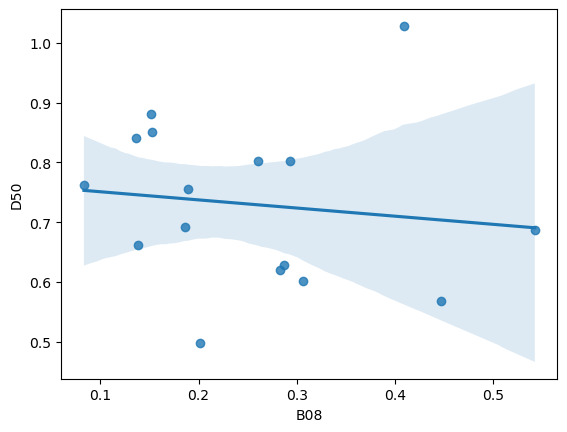

In [70]:
model_con = smf.ols(formula='D50 ~ B08', data=df).fit()
display(model_con.summary())
sns.regplot(x='B08', y='D50', data=df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1125
Date:                Wed, 15 Mar 2023   Prob (F-statistic):              0.737
Time:                        04:03:15   Log-Likelihood:                -27.198
No. Observations:                 644   AIC:                             58.40
Df Residuals:                     642   BIC:                             67.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6114      0.023     26.279      0.000       0.566       0.657
B02           -0.0270      0.080     -0.335      0.737      -0.185       0.131
==============================================================================
Omnibus:                      124.641   Durbin-Watson:                   1.166
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              299.968
Skew:                           1.009   Prob(JB):                     7.29e-66
Kurtosis:                       5.666   Cond. No.                         8.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='B02', ylabel='D50'>

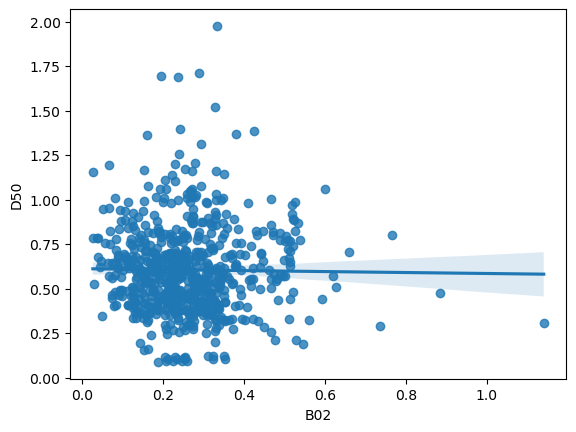

In [42]:
model = smf.ols(formula='D50 ~ B02', data=df).fit()
display(model.summary())
sns.regplot(x='B02', y='D50', data=df)
# plt.scatter(world['correlation'], world['D50'])
# plt.plot(model_corr,linestyle ='dotted')
# plt.xlabel('correlation')
# plt.ylabel('D50')
# plt.show()

# Random Forest Regression

Clearly no linearity can be found at these spatial scale (0.6m). This is likely telling us that the texture features are all but lost at this resolution for detecting particle sizes of this size (<2mm)

In [71]:
df.head()

,objectid,beach_location,D10,D50,D90,DMEAN,date,lon,lat,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,span
0,75,the_berm,0.433855,0.661307,1.077571,0.665601,2021-06-11,-123.068107,38.339941,0.1344,0.1254,0.1046,0.1382,0.1379,0.1403,0.1384,0.1391,0.2001,0.1917,0.973399
1,78,the_berm,0.577085,0.880677,1.435799,0.886127,2021-06-11,-123.068733,38.334629,0.1480,0.1352,0.1158,0.1486,0.1446,0.1468,0.1518,0.1412,0.2030,0.1964,0.975061
2,1151,the_berm,0.454081,0.687461,1.117354,0.692806,2023-02-14,-121.941207,36.618313,0.4356,0.4152,0.3718,0.4914,0.5208,0.5322,0.5424,0.5440,0.5332,0.5035,0.964816
3,739,the_berm,0.529515,0.801665,1.302974,0.807897,2022-09-15,-122.980225,38.067190,0.2800,0.2624,0.2344,0.2773,0.2796,0.2772,0.2928,0.2768,0.3184,0.3078,0.964816
4,737,the_berm,0.409044,0.619277,1.006533,0.624092,2022-09-15,-122.977104,38.074264,0.2752,0.2586,0.2264,0.2847,0.2748,0.2814,0.2832,0.2732,0.3420,0.3440,0.964816


In [72]:
y = df['D50']
X = df[BANDS]
display(X)
display(y)
type(y)

,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12
0,0.1344,0.1254,0.1046,0.1382,0.1379,0.1403,0.1384,0.1391,0.2001,0.1917
1,0.1480,0.1352,0.1158,0.1486,0.1446,0.1468,0.1518,0.1412,0.2030,0.1964
2,0.4356,0.4152,0.3718,0.4914,0.5208,0.5322,0.5424,0.5440,0.5332,0.5035
3,0.2800,0.2624,0.2344,0.2773,0.2796,0.2772,0.2928,0.2768,0.3184,0.3078
4,0.2752,0.2586,0.2264,0.2847,0.2748,0.2814,0.2832,0.2732,0.3420,0.3440
5,0.1656,0.1534,0.1266,0.1727,0.1770,0.1865,0.1894,0.1808,0.2566,0.2401
6,0.2540,0.2410,0.2130,0.2638,0.2542,0.2573,0.2606,0.2564,0.3044,0.3051
7,0.0698,0.0513,0.0395,0.0928,0.0969,0.1006,0.0833,0.1092,0.1521,0.1306
8,0.1530,0.1424,0.1146,0.1412,0.1488,0.1532,0.1858,0.1520,0.1902,0.1782
9,0.3754,0.3596,0.3280,0.4751,0.4743,0.4750,0.4468,0.4972,0.4116,0.3747


0     0.661307
1     0.880677
2     0.687461
3     0.801665
4     0.619277
5     0.755629
6     0.802582
7     0.762303
8     0.692437
9     0.567639
10    1.028774
11    0.841313
12    0.498023
13    0.627873
14    0.601559
15    0.850358
Name: D50, dtype: float64

pandas.core.series.Series

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [74]:
X_test

,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12
0,0.1344,0.1254,0.1046,0.1382,0.1379,0.1403,0.1384,0.1391,0.2001,0.1917
1,0.1480,0.1352,0.1158,0.1486,0.1446,0.1468,0.1518,0.1412,0.2030,0.1964
5,0.1656,0.1534,0.1266,0.1727,0.1770,0.1865,0.1894,0.1808,0.2566,0.2401
14,0.2758,0.2502,0.2238,0.2754,0.2590,0.2763,0.3066,0.2705,0.3496,0.3340


In [75]:
# Train the model
rf = RandomForestRegressor(n_estimators = 10, max_depth = 10, random_state = 42)
rf.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)

In [76]:
import warnings
warnings.filterwarnings('ignore')

# Make prediction
predictions = rf.predict(X_test)

result = X_test.copy()
result['D50'] = y_test
result['D50_pred'] = predictions.tolist()
result.head()

,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,D50,D50_pred
0,0.1344,0.1254,0.1046,0.1382,0.1379,0.1403,0.1384,0.1391,0.2001,0.1917,0.661307,0.806350
1,0.1480,0.1352,0.1158,0.1486,0.1446,0.1468,0.1518,0.1412,0.2030,0.1964,0.880677,0.808159
5,0.1656,0.1534,0.1266,0.1727,0.1770,0.1865,0.1894,0.1808,0.2566,0.2401,0.755629,0.607373
14,0.2758,0.2502,0.2238,0.2754,0.2590,0.2763,0.3066,0.2705,0.3496,0.3340,0.601559,0.765187


ValueError: x and y must be the same size

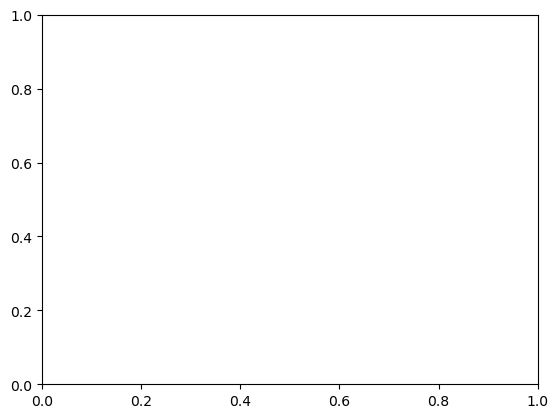

2023-03-16 22:11:18,681 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [86]:
import matplotlib.pyplot as plt

# Define x axis
x_axis = y

# Build scatterplot
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('D50-real')
plt.ylabel('D50-predicted')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()



## Tuning hyperparameters

In [87]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Find the best parameters for the model
parameters = {
    'max_depth': [70, 80, 90, 100],
    'n_estimators': [100, 500, 1000]
}
gridforest = GridSearchCV(rf, parameters, cv = 3, n_jobs = -1, verbose = 1)
gridforest.fit(X_train, y_train)
gridforest.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'max_depth': 70, 'n_estimators': 100}

In [88]:
rf = RandomForestRegressor(n_estimators = 100, max_depth = 70, random_state = 42)
rf.fit(X_train, y_train.values.ravel())


RandomForestRegressor(max_depth=70, random_state=42)

In [89]:
X_test

,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12
0,0.1344,0.1254,0.1046,0.1382,0.1379,0.1403,0.1384,0.1391,0.2001,0.1917
1,0.1480,0.1352,0.1158,0.1486,0.1446,0.1468,0.1518,0.1412,0.2030,0.1964
5,0.1656,0.1534,0.1266,0.1727,0.1770,0.1865,0.1894,0.1808,0.2566,0.2401
14,0.2758,0.2502,0.2238,0.2754,0.2590,0.2763,0.3066,0.2705,0.3496,0.3340


In [90]:
# Make prediction
predictions = rf.predict(X_test)

result = X_test.copy()
result['D50'] = y_test
result['D50_pred'] = predictions.tolist()
result.head()

,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,D50,D50_pred
0,0.1344,0.1254,0.1046,0.1382,0.1379,0.1403,0.1384,0.1391,0.2001,0.1917,0.661307,0.803168
1,0.1480,0.1352,0.1158,0.1486,0.1446,0.1468,0.1518,0.1412,0.2030,0.1964,0.880677,0.794556
5,0.1656,0.1534,0.1266,0.1727,0.1770,0.1865,0.1894,0.1808,0.2566,0.2401,0.755629,0.640431
14,0.2758,0.2502,0.2238,0.2754,0.2590,0.2763,0.3066,0.2705,0.3496,0.3340,0.601559,0.720348


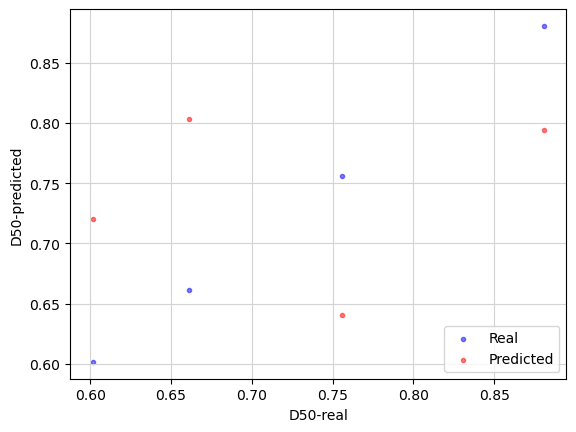

In [91]:
# Define x axis
x_axis = result.D50

# Build scatterplot
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('D50-real')
plt.ylabel('D50-predicted')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()



## Error Estimation

In [82]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-squared scores:', round(r2, 2))



Mean Absolute Error: 0.11
Mean Squared Error: 0.01
R-squared scores: -0.17


## Defining and visualizing variables importance

In [83]:
# Get features list
characteristics = X.columns
# Get the variables importances, sort them, and print the result
importances = list(rf.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: B12                  Importance: 0.31
Variable: B07                  Importance: 0.16
Variable: B11                  Importance: 0.09
Variable: B04                  Importance: 0.08
Variable: B05                  Importance: 0.07
Variable: B8A                  Importance: 0.07
Variable: B03                  Importance: 0.06
Variable: B02                  Importance: 0.06
Variable: B08                  Importance: 0.06
Variable: B06                  Importance: 0.05


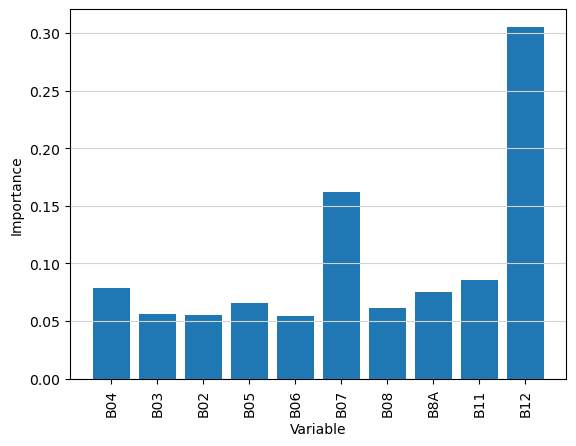

In [84]:
# Visualize the variables importances
plt.bar(characteristics, importances, orientation = 'vertical')
plt.xticks(rotation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.grid(axis = 'y', color = '#D3D3D3', linestyle = 'solid')
plt.show()